# Homework 5

We consider steady-state flow in a fully saturated porous medium.  We will assume constant porosity and viscosity for simplicity, leading to [Darcy's law](https://en.wikipedia.org/wiki/Darcy%27s_law) producing a flux
$$ q = -\kappa \nabla p $$
in terms of pressure $p$ and permeability $\kappa$.
Conservation of mass yields a Laplacian
$$ \nabla\cdot q = -\nabla\cdot \big( \kappa \nabla p \big) = 0 . $$
The velocity of the fluid is
$$ u = \frac q \phi $$
where $\phi \in (0,1]$ is porosity.

Our flow will take place on the 2D unit disc with two holes removed
$$ \left\{ x \in \mathbb R^2 : |x|<1, \big|x-(1/2,0)| > 1/4\big|, \big|x-(-1/2,0)| > 1/4\big|  \right\} . $$
The outer boundary is Neumann, corresponding to an impermeable boundary.
The left "hole" is our inejection with a relative pressure of 1 and the right is extraction with a relative pressure of 0.
We can solve for pressure as follows.

```python
mesh = Mesh(shape='eyes', reshape_boundary=True)
fe = fe2tri(2)
prob = laplacian2()
x, pressure = fe2_solve(fe, mesh, prob.form, dict(left=lambda x:0*x[:,0]+1, right=lambda x:0*x[:,0]))
pyplot.tricontourf(x[:,0], x[:,1], pressure, triangles=mesh.tri2())
pyplot.title('Pressure')
pyplot.colorbar();
```

The velocity field can be computed by taking the gradient of pressure and dividing by permeability.
Now suppose that the fluid being injected at the left hole is hot while the outflow is a colder heat sink.
Temperature will satisfy the advection-diffusion equation (with appropriate choice of units)
$$ \nabla\cdot \big( - \nabla T + u T \big) = 0 $$
with boundary conditions $T=1$ at the left (inflow) hole, $T=0$ at the right (outflow) hole, and Neumann conditions at the (insulated) outer boundary.
The homework is to solve for temperature using the velocity field defined by the pressure solution above.

* You will need to modify `fe2_solve` so that you can evaluate velocity at the quadrature points.
* You will need to write a `form` function that implements the weak form of the advection-diffusion equation for temperature.

With respect to your numerically computed solutions, think about the following questions.

1. What is the order of accuracy of $p$, $u$, and $T$ for linear `fe2tri(1)` and quadratic `fe2tri(2)` elements? Rather than interpolating to compare in a norm, you can compare by computing moments of the error, such as
$$ \int_\Omega x (u_{2h} - u_h)(x,y) = \int_\Omega x u_{2h}(x,y) - \int_\Omega x u_h(x,y), $$
where the two integrals on the right can be carried out on the natural quadrature of each mesh independently.

2. When porosity $\phi$ decreases (at fixed permeability), the velocity increases.  Can you obtain an accurate solution for $T$ for any value of $\phi$ or is there a relationship between $\phi$ and the grid size $h$?


In [1]:
%precision 3
#%matplotlib notebook
%matplotlib inline

import numpy
from matplotlib import pyplot
pyplot.style.use('ggplot')

import scipy.sparse as sp
import scipy.sparse.linalg
from scipy.optimize import fsolve

%run hw_support.py

## Solve for Temperature

From the problem description, temperature satisfies the following differential equation, with boundary conditions $T=1$ at the left (inflow) hole, $T=0$ at the right (outflow) hole, and Neumann conditions at the (insulated) outer boundary.
$$ \nabla\cdot \left( - \nabla T + u T \right) = 0 $$
To solve this using a finite element method, we first rewrite the equation using a weak form, which will look like
$$ \int_\Omega v\cdot f_0(T, \nabla T) + \nabla v\cdot f_1(T, \nabla T) = 0, \quad \forall v$$
To do this, we first multiple by a test function $v$ and integrate the differential equation.
$$\int_\Omega v \left ( \nabla\cdot \left( - \nabla T + u T \right) \right) = 0$$
Then, we rewrite:
$$- \int_\Omega \nabla v \cdot \left ( - \nabla T + u T \right) + \int_{\partial \Omega} v \left( - \nabla T + u T \right) \cdot \hat n = 0$$
The second integral addresses boundary conditions, and we don't need it now. The equation above simplies to
$$\int_\Omega \nabla v \cdot \left (\nabla T - u T \right) = 0$$
This is in the form we want, using the following values:
\begin{align}
&f_0(T, \nabla T) = 0 &f_1(T, \nabla T) = \nabla T - u T
\end{align}
Now that we have the weak form we need, we can start writing it into code. In the $f_1$ equation above, note the dependence on $u$, the velocity field, in $f_1$. We'll need support for that in `fe2_solve`, but, for now, it'll be a parameter in the `form` function.

In [2]:
class temperature:
    def __init__(self):
        return
    def form(self, x, T, dT, vel):
        '''
        Returns: two pairs, f and df
          f (f_0, f_1): 
            f functions of the temperature equation's weak form evaluated at 
            the quadrature points
          df (df_0, df_1):
            each df_i is a pair, with this form
            ((derivative of f_i with respect to T), 
             (derivative of f_i with respect to grad(T)))
        '''
        ## f0 = 0
        ## f1 = grad(T) - u*T
        ## df1/dT = -u
        ## df1/d(grad(T)) = 1
        
        velT = vel * numpy.array([T]).T
        f1 = dT - velT
        return (0, f1), ((0, 0), (-vel, numpy.eye(2)[None,:,:]))

Velocity is $u = q/\phi$, where $q = -\kappa \nabla p$ is the flux and $\phi \in \left(0, 1\right]$ is porosity; for this assignment, we'll use the value $\kappa = 1$. Now, on our way to calculating the flux, the code below, taken from the problem statement, solves the pressure equation derived from Darcy's Law.

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.


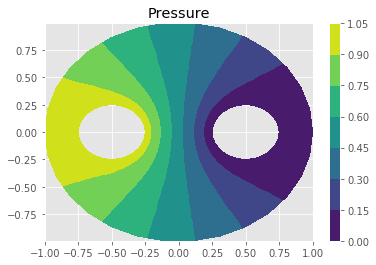

In [3]:
mesh = Mesh(shape='eyes', reshape_boundary=True)
fe = fe2tri(2)

kappa = 1
prob = laplacian2(k = kappa)
x, pressure = fe2_solve(fe, mesh, prob.form, dict(left=lambda x:0*x[:,0]+1, right=lambda x:0*x[:,0]))

pyplot.tricontourf(x[:,0], x[:,1], pressure, triangles=mesh.tri2())
pyplot.title('Pressure')
pyplot.colorbar();

With this, we can start on a solution for the temperature problem, the code for which continues below. The solver is a modification to `fe2_solve` from the lecture, which takes a new parameter that lets us pass in the pressure solution and other velocity-related information. 

In [4]:
class velocity_components:
    '''
    Provides the additional parameter (velocity evaluated at quadrature points)
    required for solving the temperature equation with an FEM.
    
    An instance of this class can be passed to fe2_solve_hw5 along with the
    temperature form.
    '''
    def __init__(self, pressure, kappa = 1, phi = 0.5):
        self.pressure = pressure
        self.kappa = kappa
        self.phi = phi
        return
    def evaluate(self, E, B, D, dXdxe):
        Dxuq = numpy.einsum('ixX,iX->ix', dXdxe, D @ self.pressure[E])
        return -1 * (self.kappa / self.phi) * Dxuq

def fe2_solve_hw5(fe, mesh, form, other_params, dirichlet={}, spy=False, verbose=False):
    x, Erestrict = mesh.Erestrict(fe.p)
    Frestrict = mesh.Frestrict(fe.p)
    Ndof = len(x)
    B, D = fe.B, fe.D
    xq, W, dXdx = fe2_geom(fe, mesh)
    dirichletidx = []
    bcmask = numpy.zeros(Ndof, dtype=bool)    
    for label, func in dirichlet.items():
        indices = Frestrict[mesh.boundary[label]].flatten()
        dirichletidx.append((label, indices, func))
        bcmask[indices] = True
    
    def project_dirichlet_hw5(u): # Affine projector into space satisfying Dirichlet BC
        ubc = u.copy()
        for label, indices, func in dirichletidx:
            ubc[indices] = func(x[indices])
        return ubc

    def residual_hw5(u):
        ubc = project_dirichlet_hw5(u)
        v = u - ubc
        for e, E in enumerate(Erestrict):
            uE = ubc[E]
            uq = B @ uE
            add_params = other_params.evaluate(E, B, D, dXdx[e])
            Dxuq = numpy.einsum('ixX,iX->ix', dXdx[e], D @ uE)
            f, _ = form(xq[e], uq, Dxuq, add_params)
            vE = B.T @ (W[e] * f[0]) + numpy.einsum('iXp,ixX,ix->p',
                                                    D, dXdx[e], W[e,:,None] * f[1])
            vE[bcmask[E]] = 0
            v[E] += vE
        return v
    
    def jacobian_hw5(u):
        ubc = project_dirichlet_hw5(u)
        ai = []
        aj = []
        aa = []
        for e, E in enumerate(Erestrict):
            uE = ubc[E]
            add_params = other_params.evaluate(E, B, D, dXdx[e])
            Dx = numpy.einsum('ixX,iXp->ixp', dXdx[e], D)
            _, df = form(xq[e], B @ uE, Dx @ uE, add_params)
            Ae = (numpy.einsum('qi,q,qj->ij', B, W[e] * df[0][0], B) +
                  + numpy.einsum('qi,qy,qyj->ij', B, W[e,:,None] * df[0][1], Dx) +
                  + numpy.einsum('qxi,qx,qj->ij', Dx, W[e,:,None] * df[1][0], B) +
                  + numpy.einsum('qxi,qxy,qyj->ij', Dx, W[e,:,None,None] * df[1][1], Dx))
            Ae[bcmask[E],:] = 0
            Ae[:,bcmask[E]] = 0
            ai += numpy.outer(E, numpy.ones_like(E)).flatten().tolist()
            aj += numpy.outer(numpy.ones_like(E), E).flatten().tolist()
            aa += Ae.flatten().tolist()
        bcidx = numpy.where(bcmask)[0].tolist()
        ai += bcidx
        aj += bcidx
        aa += numpy.ones_like(bcidx).tolist()
        A = sp.csr_matrix((aa, (ai, aj)), shape=(Ndof,Ndof))
        if spy:
            pyplot.spy(A)
        return A
    
    u0 = numpy.zeros(Ndof) # initial guess
    u, nit = fsolve_newton(residual_hw5, jacobian_hw5, u0, verbose=verbose)
    return x, u

Next is a solution for the problem using the pressure and $\kappa$ values from before, along with porosity $\phi=0.5$.

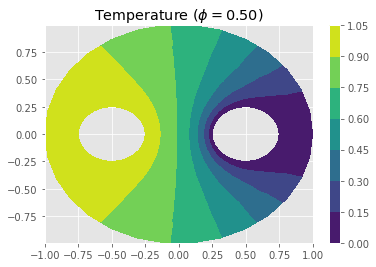

In [5]:
def solve_temp(mesh, p, k, phi, plot_temp = False, verbose=False):
    fe = fe2tri(p)
    
    prob = laplacian2(k=k)
    x_pressure, pressure = fe2_solve(fe, mesh, prob.form, dict(left=lambda x:0*x[:,0]+1, right=lambda x:0*x[:,0]), verbose=False)
    
    temp_prob = temperature()
    vel_pieces = velocity_components(pressure, kappa=k, phi=phi)
    x_temp, temp_soln = fe2_solve_hw5(fe, mesh, temp_prob.form, vel_pieces, dict(left=lambda x:0*x[:,0]+1, right=lambda x:0*x[:,0]), verbose=False)
    
    if plot_temp:
        triangles = mesh.tri if (p == 1) else mesh.tri2()
        pyplot.figure()
        pyplot.tricontourf(x_temp[:,0], x_temp[:,1], temp_soln, triangles=triangles)
        pyplot.title("Temperature ($\phi ={:.2f}$)".format(phi))
        pyplot.colorbar();
        
    return x_temp, temp_soln

phi = 0.5
solve_temp(mesh, 2, kappa, phi, plot_temp = True);

Here are two more solutions, using $\phi = 0.2$ and $\phi = 0.8$.

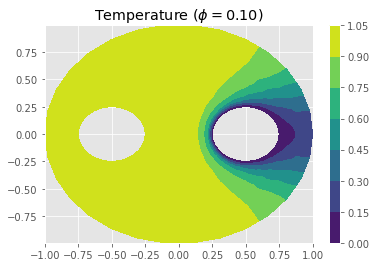

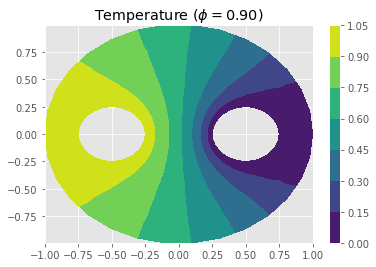

In [6]:
solve_temp(mesh, 2, kappa, 0.1, plot_temp = True);
solve_temp(mesh, 2, kappa, 0.9, plot_temp = True);

With lower porosity, more of the disk remains hot. With higher porosity, more cools down.

## Solution Evaluation

We'll look at the solution we get using linear and quadratic finite elements ($p=1$ and $p=2$). Using the same values $\kappa = 1$ and $\phi = 0.5$, here's a look at the solution with linear elements. (Quadratic elements were used for the plot above.)

    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (edge length ratio 4.000). Skipping.
    Subdomain boundary inhomogeneous (

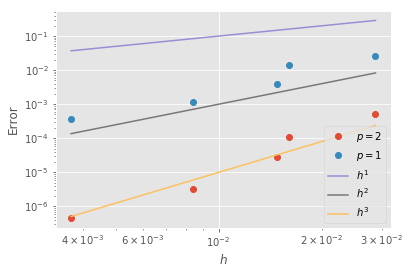

In [7]:
def calculate_sum(fe, mesh, T):
    x, Erestrict = mesh.Erestrict(fe.p)
    B = fe.B
    xq, W, dXdx = fe2_geom(fe, mesh)
        
    isum = 0
    for e,E in enumerate(Erestrict):
        Tq = B @ T[E]
        isum += numpy.sum(W[e] * (Tq * xq[e][:,0]))
    return isum


def error(lcar, p, k, phi, verbose=False):
    fe = fe2tri(p)
    mesh = Mesh(lcar, shape='eyes', reshape_boundary=True)
    mesh_refined = Mesh(lcar / 2, shape='eyes', reshape_boundary=True)
    
    x_temp_c, temp_soln_c = solve_temp(mesh, p, k, phi, verbose=verbose)
    x_temp_r, temp_soln_r = solve_temp(mesh_refined, p, k, phi, verbose=verbose)
                          
    sum_coarse = calculate_sum(fe, mesh, temp_soln_c)
    sum_refined = calculate_sum(fe, mesh_refined, temp_soln_r)
                          
    error = numpy.abs(sum_coarse - sum_refined)
                          
    return [mesh.h, error]


def plot_errors(k, phi):
    lcars = numpy.geomspace(.1, 1, 5)[::-1]
    
    r_2 = numpy.array([error(lcar, 2, k, phi) for lcar in lcars])
    hs_2, errors_2 = r_2[:,0], r_2[:,1]
    
    r_1 = numpy.array([error(lcar, 1, k, phi) for lcar in lcars])
    hs_1, errors_1 = r_1[:,0], r_1[:,1]
    
    pyplot.figure()
    pyplot.loglog(hs_2, errors_2, 'o', label='$p=2$')
    pyplot.loglog(hs_1, errors_1, 'o', label='$p=1$')
    for power in (1,2,3):
        pyplot.loglog(hs_2, 10 * hs_2**power, label='$h^{}$'.format(power))
    pyplot.xlabel('$h$')
    pyplot.ylabel('Error')
    pyplot.legend();

plot_errors(1, 0.5);

It looks like the error of the solutions using quadratic elements ($p=2$) varies cubicly, while the errors using only linear elements ($p=1$) are quadratic.

## Porosity & Grid Size

Next, we'll look at what happens to the solution as porosity changes.